In [1]:
from data.germeval2017 import germeval2017_dataset

from misc.preferences import PREFERENCES
from misc.visualizer import *
from misc.hyperparameters import get_default_params
from optimizer import get_default_optimizer
from misc import utils
from models.transformer.encoder import TransformerEncoder
from models.softmax_output import SoftmaxOutputLayerWithCommentWiseClass
from models.transformer_tagger import TransformerTagger
from models.transformer.train import Trainer
from criterion import NllLoss

C:\Users\felix\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


ModuleNotFoundError: No module named 'misc.hyperparameters'

In [ ]:
experiment_name = 'generalSentimentStdModel25Ep'
use_cuda = True

In [35]:
PREFERENCES.defaults(
    data_root='./data/germeval2017',
    data_train='train_v1.4.tsv',    
    data_validation='dev_v1.4.tsv',
    data_test='test_TIMESTAMP1.tsv',
    early_stopping='highest_5_F1'
)

hyper_parameters = get_default_params()
hyper_parameters.model_size = 300
hyper_parameters.batch_size = 12
hyper_parameters.early_stopping = -1
experiment_name = utils.create_loggers(experiment_name=experiment_name)

Log path is  C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\logs\generalSentimentStdModel15Ep


In [36]:
germeval2017_dataset = germeval2017_dataset( hyper_parameters.batch_size,
                              root=PREFERENCES.data_root,
                              train_file=PREFERENCES.data_train,
                              validation_file=PREFERENCES.data_validation,
                              test_file=PREFERENCES.data_test,
                              use_cuda=use_cuda)



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


+-------------------------+
|  GERM EVAL 2017 DATASET |
+---------------+---------+
|     Split     |   Size  |
+---------------+---------+
|     train     |  17043  |
|   validation  |   2049  |
|      test     |   2095  |
+---------------+---------+
+--------------------+
|  Vocabulary Stats  |
+------------+-------+
| Vocabulary |  Size |
+------------+-------+
|  Comments  | 95161 |
| Sentiment  |   4   |
+------------+-------+


In [37]:
# 10 words with a 100-length embedding
target_vocab = germeval2017_dataset['vocabs'][1]
target_size = len(target_vocab)
print('Targets:',target_vocab.freqs.keys())
print(target_vocab.freqs)
print(target_vocab.itos)
class_labels = target_vocab.itos

Targets: dict_keys(['neutral', 'positive', 'negative'])
Counter({'neutral': 10599, 'negative': 5228, 'positive': 1216})
[' UNK ', 'neutral', 'negative', 'positive']


In [38]:
total_samples = 0
for l, freq in target_vocab.freqs.items():
    print('{}: {}'.format(l, freq))
    total_samples += freq
print('\nTotal Samples:',total_samples)

print('\n\nTrivial classifiers')
for l, freq in target_vocab.freqs.items():
    acc = float(freq) / float(total_samples)
    print('Trivial {}: {}%'.format(l, acc*100))

neutral: 10599
positive: 1216
negative: 5228

Total Samples: 17043


Trivial classifiers
Trivial neutral: 62.18975532476677%
Trivial positive: 7.1348940914158305%
Trivial negative: 30.6753505838174%


In [39]:
loss = NllLoss(target_size)
# transformer = GoogleTransformer(True, target_size, target_size, num_units, 2, 2, 512, 0.1)
transformer = TransformerEncoder(germeval2017_dataset['embeddings'][0],
                                 n_enc_blocks=2,
                                 n_head=3,
                                 d_model=hyper_parameters.model_size,
                                 d_k=100,
                                 d_v=100)
tagging_softmax = SoftmaxOutputLayerWithCommentWiseClass(hyper_parameters.model_size, target_size)
model = TransformerTagger(transformer, tagging_softmax)


In [40]:
# predict now to see model in final state
#df = predict_some_examples_to_df(model, conll2003['iters'][1], num_samples=400)
#print(df)

In [41]:
optimizer = get_default_optimizer(model, hyper_parameters)
trainer = Trainer(target_size, 
                    model,
                    loss,
                    optimizer,
                    hyper_parameters,
                    germeval2017_dataset['iters'],
                    experiment_name,
                    log_every_xth_iteration=-1,
                    enable_tensorboard=True,
                    dummy_input=germeval2017_dataset['dummy_input'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1              [-1, 42, 300]      28,548,300
           Dropout-2              [-1, 42, 300]               0
PositionalEncoding2-3              [-1, 42, 300]               0
            Linear-4              [-1, 42, 300]          90,000
            Linear-5              [-1, 42, 300]          90,000
            Linear-6              [-1, 42, 300]          90,000
           Dropout-7               [-1, 42, 42]               0
ScaledDotProductAttentionLayer-8              [-1, 42, 100]               0
            Linear-9              [-1, 42, 300]          90,000
          Dropout-10              [-1, 42, 300]               0
        LayerNorm-11              [-1, 42, 300]               0
MultiHeadedSelfAttentionLayer-12              [-1, 42, 300]               0
           Linear-13             [-1, 42, 2048]         616,448
           Lin


pre_training - INFO - TransformerTagger (
  (encoder): TransformerEncoder(
    (src_embeddings): Embedding(95161, 300)
    (positional_encoding): PositionalEncoding2(
      (dropout): Dropout(p=0.1)
    )
    (encoder_blocks): ModuleList(
      (0): EncoderBlock(
        (self_attention_layer): MultiHeadedSelfAttentionLayer(
          (query_projections): Linear(in_features=300, out_features=300, bias=False)
          (key_projections): Linear(in_features=300, out_features=300, bias=False)
          (value_projections): Linear(in_features=300, out_features=300, bias=False)
          (attention_layer): ScaledDotProductAttentionLayer(
            (dropout): Dropout(p=0.1)
          )
          (layer_norm): LayerNorm()
          (w_0): Linear(in_features=300, out_features=300, bias=False)
          (dropout): Dropout(p=0.1)
        )
        (feed_forward_layer): PointWiseFCLayer(
          (layer_norm): LayerNorm()
          (w_1): Linear(in_features=300, out_features=2048, bias=True)


In [42]:
result = trainer.train(15, True, False)

pre_training - DEBUG - train with cuda support
pre_training - DEBUG - train with cuda support
pre_training - DEBUG - train with cuda support
pre_training - DEBUG - train with cuda support
pre_training - DEBUG - train with cuda support
pre_training - INFO - 1421 Iterations per epoch with batch size of 12
pre_training - INFO - 1421 Iterations per epoch with batch size of 12
pre_training - INFO - 1421 Iterations per epoch with batch size of 12
pre_training - INFO - 1421 Iterations per epoch with batch size of 12
pre_training - INFO - 1421 Iterations per epoch with batch size of 12
pre_training - INFO - START training.
pre_training - INFO - START training.
pre_training - INFO - START training.
pre_training - INFO - START training.
pre_training - INFO - START training.





A Jupyter Widget

A Jupyter Widget

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	1421	86.507		7.488		0.623		0.623		3.57m - 3.6m / 0.0m


A Jupyter Widget

A Jupyter Widget

2	2842	18.694		1.908		0.301		0.301		3.51m - 7.1m / 53.5m


A Jupyter Widget

A Jupyter Widget

3	4263	4.468		0.985		0.640		0.640		3.51m - 10.6m / 52.8m


A Jupyter Widget

A Jupyter Widget

4	5684	2.161		1.194		0.301		0.301		3.50m - 14.3m / 52.9m


A Jupyter Widget

A Jupyter Widget

5	7105	1.391		1.044		0.621		0.621		3.48m - 17.8m / 52.8m


A Jupyter Widget

A Jupyter Widget

6	8526	1.129		1.029		0.622		0.622		3.46m - 21.4m / 52.8m


A Jupyter Widget

A Jupyter Widget

7	9947	1.040		1.001		0.630		0.630		3.48m - 25.0m / 52.7m


A Jupyter Widget

A Jupyter Widget

8	11368	0.990		1.017		0.619		0.619		3.49m - 28.6m / 53.0m


A Jupyter Widget

A Jupyter Widget

9	12789	1.001		1.011		0.674		0.674		3.54m - 32.2m / 53.0m


A Jupyter Widget

A Jupyter Widget

10	14210	0.941		1.010		0.624		0.624		3.52m - 35.8m / 53.5m


A Jupyter Widget

A Jupyter Widget

11	15631	0.911		1.057		0.582		0.582		3.52m - 39.4m / 53.4m


A Jupyter Widget

A Jupyter Widget

12	17052	0.908		0.978		0.660		0.660		3.50m - 42.9m / 53.5m


A Jupyter Widget

A Jupyter Widget

13	18473	0.847		0.979		0.685		0.685		3.57m - 46.7m / 53.6m


A Jupyter Widget

A Jupyter Widget

14	19894	0.806		1.013		0.675		0.675		3.59m - 50.4m / 54.0m


A Jupyter Widget

A Jupyter Widget

15	21315	0.827		0.969		0.628		0.628		3.68m - 54.1m / 54.0m


In [19]:
plt.rcParams['figure.figsize'] = [10, 10]

In [20]:
model = result['model']

In [21]:
result_labels = trainer.classify_sentence('I was born in 1993 in Stuttgart')



print(result_labels)

TypeError: 'int' object is not iterable

In [22]:
tr = trainer.text_reverser[1]
lr = trainer.label_reverser

test_sentence = ['china', 'controlled', 'most', 'of', 'the', 'match']
test_sentence

['china', 'controlled', 'most', 'of', 'the', 'match']

In [25]:
test_sentence = tr.preprocess('Die Bahn ist nicht gut')

#test_sentence = tr.preprocess('china controlled most of the match on 1993')
test_sentence = [x.strip(' ') for x in test_sentence]
test_sentence = [test_sentence]
test_sentence

[['die', 'bahn', 'ist', 'nicht', 'gut']]

In [26]:

#test = tr.preprocess('china controlled most of the match')
#print(test)

#test_sentence = [['china', 'controlled', 'most', 'of', 'the', 'match']]
x = tr.process(test_sentence)

print("X TENSOR ",x)
print('X Size', x.size())
print("Reversed X", tr.reverse(x))
x = x.cuda()
y_hat = model.predict(x)
y_hat_label = lr.reverse(y_hat)
print(y_hat_label)



X TENSOR  tensor([[0, 0, 0, 0, 0]])
X Size torch.Size([1, 5])
Reversed X ['UNK UNK UNK UNK UNK']


TypeError: 'int' object is not iterable

pre_training - INFO - Perform final model evaluation
pre_training - INFO - Perform final model evaluation
pre_training - INFO - Perform final model evaluation
pre_training - DEBUG - --- Train Scores ---
pre_training - DEBUG - --- Train Scores ---
pre_training - DEBUG - --- Train Scores ---


A Jupyter Widget

pre_training - INFO - TRAIN loss:	0.996072684455975
pre_training - INFO - TRAIN loss:	0.996072684455975
pre_training - INFO - TRAIN loss:	0.996072684455975
pre_training - INFO - TRAIN f1-s:	0.6199272812573305
pre_training - INFO - TRAIN f1-s:	0.6199272812573305
pre_training - INFO - TRAIN f1-s:	0.6199272812573305
pre_training - INFO - TRAIN accuracy:	0.6202546500029338
pre_training - INFO - TRAIN accuracy:	0.6202546500029338
pre_training - INFO - TRAIN accuracy:	0.6202546500029338
pre_training - DEBUG - --- Valid Scores ---
pre_training - DEBUG - --- Valid Scores ---
pre_training - DEBUG - --- Valid Scores ---


A Jupyter Widget

pre_training - INFO - VALID loss:	1.046079124282662
pre_training - INFO - VALID loss:	1.046079124282662
pre_training - INFO - VALID loss:	1.046079124282662
pre_training - INFO - VALID f1-s:	0.5861395802830649
pre_training - INFO - VALID f1-s:	0.5861395802830649
pre_training - INFO - VALID f1-s:	0.5861395802830649
pre_training - INFO - VALID accuracy:	0.5861395802830649
pre_training - INFO - VALID accuracy:	0.5861395802830649
pre_training - INFO - VALID accuracy:	0.5861395802830649


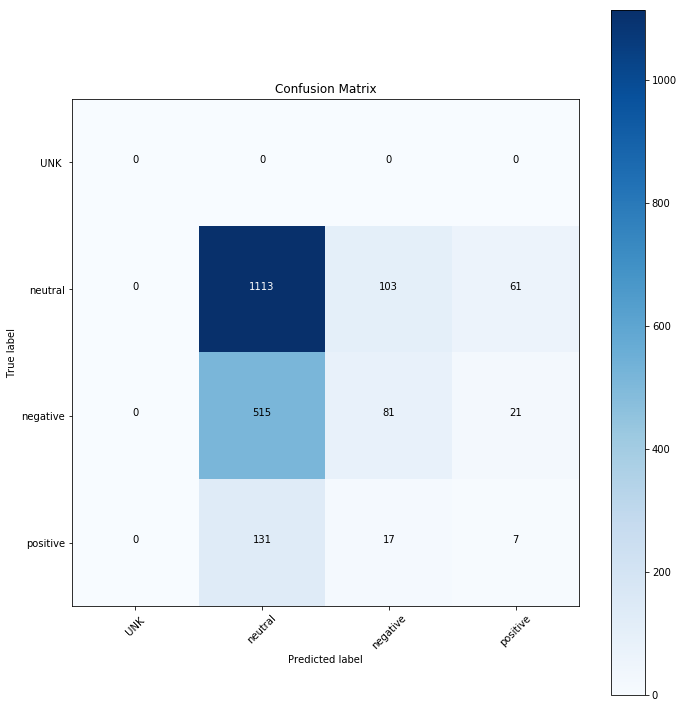

A Jupyter Widget

pre_training - INFO - TEST loss:	1.0592460236287629
pre_training - INFO - TEST loss:	1.0592460236287629
pre_training - INFO - TEST loss:	1.0592460236287629
pre_training - INFO - TEST f1-s:	0.5460620525059666
pre_training - INFO - TEST f1-s:	0.5460620525059666
pre_training - INFO - TEST f1-s:	0.5460620525059666
pre_training - INFO - TEST accuracy:	0.5460620525059666
pre_training - INFO - TEST accuracy:	0.5460620525059666
pre_training - INFO - TEST accuracy:	0.5460620525059666


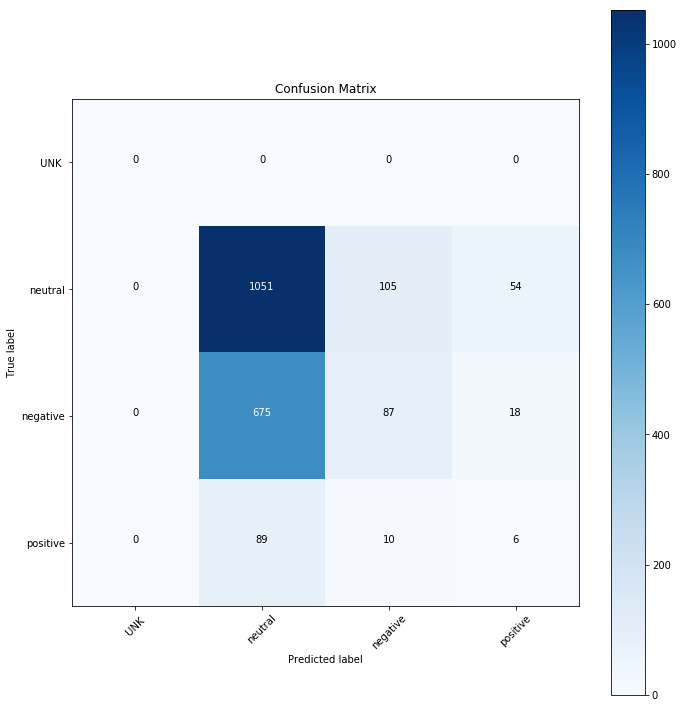

In [27]:
trainer.tb_writer = None
trainer.enable_tensorboard = False
evaluation_results = trainer.perform_final_evaluation()

In [ ]:
c_matrix = evaluation_results[1][2]
c_matrix

In [ ]:
fig = plot_confusion_matrix(c_matrix, class_labels)
plt.show()

In [ ]:
fig = plot_confusion_matrix(c_matrix, class_labels, normalize=True)
plt.show()

In [ ]:
# predict now to see model in final state
from IPython.display import display, HTML

df = predict_some_examples_to_df(model, conll2003['iters'][2], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
df = predict_some_examples_to_df(model, conll2003['iters'][1], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
df = predict_some_examples_to_df(model, conll2003['iters'][0], num_samples=800)
display(HTML(df.to_html()))

In [ ]:
import numpy as np
a = np.array([
    np.array([[1, 1], [1, 1]]),
    np.array([[2, 2], [-2, -3]])
])
print(a)

In [ ]:
a.sum(axis=0)

In [ ]:
#df = predict_some_examples_to_df(model, test_sample_iter)
#print(df)

In [ ]:
#print(result)

In [ ]:
(tr_loss, tr_f1) = result['result_train']
